### 1. Four classifier: original, one with only sleep as feature, one only train on sleep class and one only train on awake class.

### 2. For 231 and 222_1, sleep classifier performs better than the awake classifier. 

### 3. For original classifier, the accuracy for sleep class is lower than that for awake class

### 4. Consider stratified both sleep class and label

In [1]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator

from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import jj_basic_fn as JJ
from sklearn import ensemble
import seaborn as sns
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv


import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules

#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hp/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:



features_list = ['delta', 'beta','low_gamma']
plot_3d_var_list = ['beta2', 'beta4','low_gamma3']


import pickle
p231, p222_1, p222_2= pickle.load(open(hp.prepath_pat + '231' +'_trained.p', "rb" )),pickle.load(open(hp.prepath_pat + '222_1' +'_trained.p', "rb" )), pickle.load(open(hp.prepath_pat + '222_2' +'_trained.p', "rb" ))
p229 = pickle.load(open(hp.prepath_pat + '229.p', "rb" ))


## 1. Data loading

### What the data looks like

In [3]:
pat = p229
display(pd.DataFrame(pat.features))
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', 10)
print('The number of EEG segments that come from long episode is ' + str(pat.features.shape[0]))
print('The number of EEG segments that come from schduled is ' + str(47))
display(pd.DataFrame(pat.features['label'].value_counts()))

,filename,region_start_time,sleep,delta1,delta2,...,i34,epoch,label,id,if_stimulated
1633,1.315205e+17,2017-10-09 05:42:50.025600,1.0,696.474474,585.337654,...,16.0,0,True,229,False
1634,1.315205e+17,2017-10-09 05:44:47.011200,1.0,833.779602,651.250164,...,14.0,0,True,229,False
1635,1.315205e+17,2017-10-09 06:24:09.014400,1.0,203.235705,264.172585,...,27.0,0,True,229,False
1636,1.315205e+17,2017-10-09 10:57:08.035200,0.0,112.641848,110.515245,...,0.0,0,True,229,False
1637,1.315211e+17,2017-10-10 05:02:15.014400,1.0,986.767934,332.538069,...,20.0,0,True,229,False
...,...,...,...,...,...,...,...,...,...,...,...
2756,1.317894e+17,2018-08-16 17:45:36.000000,0.0,188.390445,81.944321,...,10.0,44,NaN,229,False
2757,1.317894e+17,2018-08-16 18:06:12.038400,0.0,132.213529,88.943208,...,21.0,44,NaN,229,False
2758,1.317900e+17,2018-08-17 07:43:03.993600,1.0,1038.607144,484.303792,...,23.0,44,NaN,229,False
2759,1.317900e+17,2018-08-17 07:43:59.980800,1.0,1361.269966,275.963029,...,31.0,44,NaN,229,False


The number of EEG segments that come from long episode is 1128
The number of EEG segments that come from schduled is 47


,label
False,841
True,238


In [4]:
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns',25)
display(pd.DataFrame(pat.features))


,filename,region_start_time,sleep,delta1,delta2,delta3,delta4,theta1,theta2,theta3,theta4,alpha1,...,high_gamma3,high_gamma4,all1,all2,all3,all4,i12,i34,epoch,label,id,if_stimulated
1633,1.315205e+17,2017-10-09 05:42:50.025600,1.0,696.474474,585.337654,179.407563,692.198432,453.077808,768.757884,164.028258,536.489433,185.505068,...,13.599686,25.202656,1603.706866,4619.270803,743.910832,1968.323736,28.0,16.0,0,True,229,False
1634,1.315205e+17,2017-10-09 05:44:47.011200,1.0,833.779602,651.250164,164.036945,828.162406,568.359164,825.928353,181.207567,656.595252,443.331936,...,13.563658,21.172662,2100.923760,3793.897019,656.189079,1974.650835,34.0,14.0,0,True,229,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,1.317900e+17,2018-08-17 07:43:59.980800,1.0,1361.269966,275.963029,229.028323,300.175758,750.342462,312.040753,127.381481,181.300927,64.454684,...,12.422744,21.039243,2257.715788,1286.690771,621.363663,952.941096,47.0,31.0,44,NaN,229,False
2760,1.317900e+17,2018-08-17 08:45:01.008000,0.0,102.395727,74.733764,44.222771,33.856310,241.515239,82.363732,53.108914,83.454751,93.105317,...,14.509534,29.707683,592.817317,433.767522,203.620231,434.068809,34.0,18.0,44,NaN,229,False


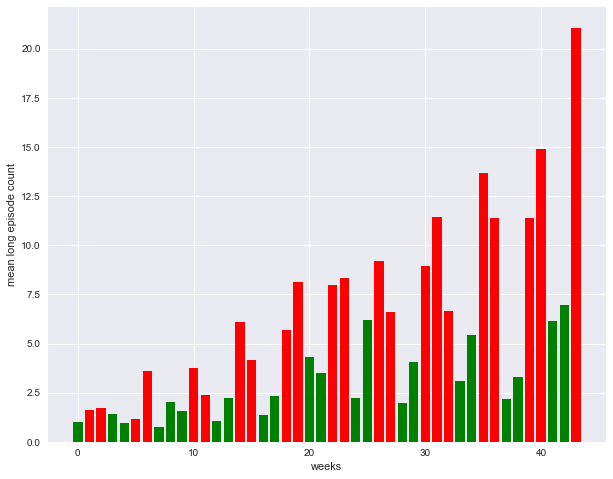

{0: True,
 1: False,
 2: False,
 3: True,
 4: True,
 5: False,
 6: False,
 7: True,
 8: False,
 9: True,
 10: False,
 11: False,
 12: True,
 13: False,
 14: False,
 15: False,
 16: True,
 17: False,
 18: False,
 19: False,
 20: False,
 21: True,
 22: False,
 23: False,
 24: True,
 25: False,
 26: False,
 27: False,
 28: True,
 29: False,
 30: False,
 31: False,
 32: False,
 33: True,
 34: False,
 35: False,
 36: False,
 37: True,
 38: False,
 39: False,
 40: False,
 41: True,
 42: False,
 43: False}

In [8]:
p229 = pickle.load(open(hp.prepath_pat + '229.p', "rb" ))

plot_funcs.plot_epoch_mean([p229], 1)
pat.epoch_label_dict


In [7]:
np.median(np.array([1,2,3,4]))

2.5

In [85]:
dat = pat.daily

dat_epi_agg, dat_le_agg, dat_epi_agg_ste, dat_le_agg_ste = prep.dat_agg(dat)
window_size = 4
means = []
vals_epi = []
for i in range(len(dat_le_agg) // 4):
    start = i * window_size
    end = i * window_size + 3
    mean = np.mean(np.array(dat_le_agg[start:end]))
    means.append(mean)
    labels = np.array(dat_le_agg.loc[start:end,hp.col_le] < mean)
    print(labels)
    vals_epi.append(labels)


[ True False False  True]
[ True  True False  True]
[ True  True False  True]
[ True  True False False]
[ True  True False False]
[ True  True False False]
[ True False False False]
[ True  True False False]
[False  True False False]
[False  True  True False]
[False  True  True False]


In [ ]:
dat_le_agg.loc[0:4]

In [ ]:
thres_epi = np.median(dat_epi_agg)
    vals_epi = list(np.array(dat_epi_agg.loc[:,col_es] < thres_epi))
    epoch_label_epi = dict(zip(keys_epi, vals_epi))
    for key_epi in epoch_label_epi:
        val_epi = epoch_label_epi[key_epi]
        dat.loc[dat['epoch'] == key_epi,'label_epi'] = val_epi
    
    # generate label according to long episode
    thres = np.median(dat_le_agg)
    keys = list(np.array(dat_le_agg.index, dtype = int))
    vals = list(np.array(dat_le_agg.loc[:,col_le] < thres))
    epoch_label = dict(zip(keys, vals))
    for key in epoch_label:
        val = epoch_label[key]
        dat.loc[dat['epoch'] == key,'label'] = val

## 2. Building Classifiers
### Fitting 7 classfier to the training data and tune the hyperparameter using 10-fold cross-validation. Evaluate the performance of each classifier using test data

### 1:'Logistic Regression' (regulation type, regulation parameter)
### 2: 'SVM' (kernel type, degreee, regulation type, regulation parameter)
### 3: 'Gaussian Naive Bayes classifier'
### 4:'Linear Discriminant Analysis'
### 5:'Decision Tree' (criterion for splliting, max depth, min sample per leaf)
### 6:'Random Forest' (criterion for splliting, number of trees, number of features used in each  tree, max depth, min sample per leaf)
### 7:'Gradient Boosting' (number of estimator, number of samples used in each estimator, max depth, min sample per leaf, learning rate)

## 3. Classifier Performance

### Performace Overview of each Classifier

### The confusion matrix and ROC of Logistic Regression (the best classifier in this case)

Confusion matrix, without normalization


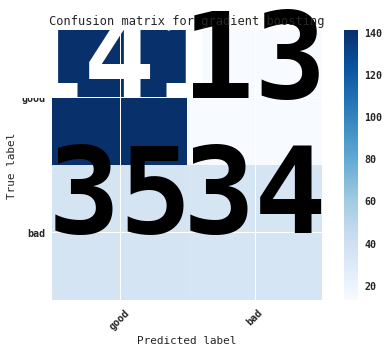

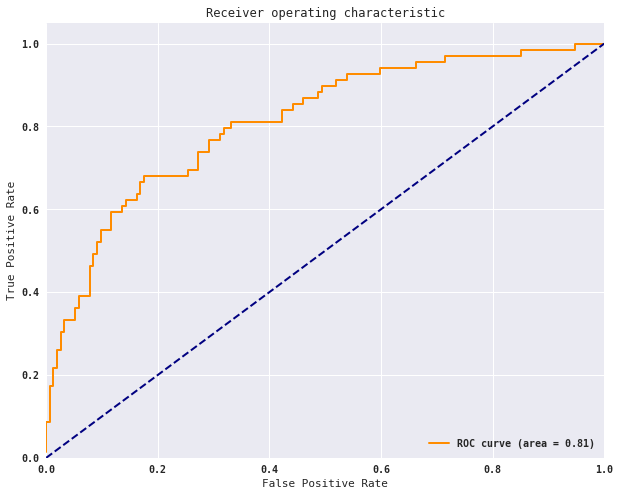

In [16]:


X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_scaler = 1, if_remove_icd = 1, if_remove_sleep = 1)
JJ.estimator_performance(7, X_test, y_test, pat = pat, if_plot_c = 1, if_plot_roc = 1)

### ROC curve for all classifiers

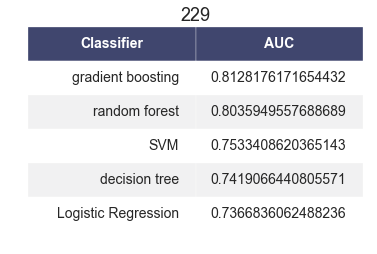

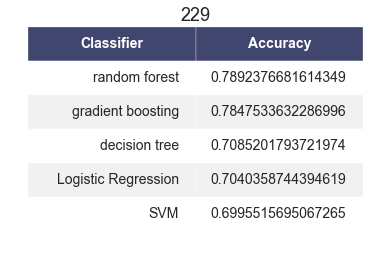

In [6]:
JJ.scores_estimators(X_test, y_test, pat = pat, label='229')

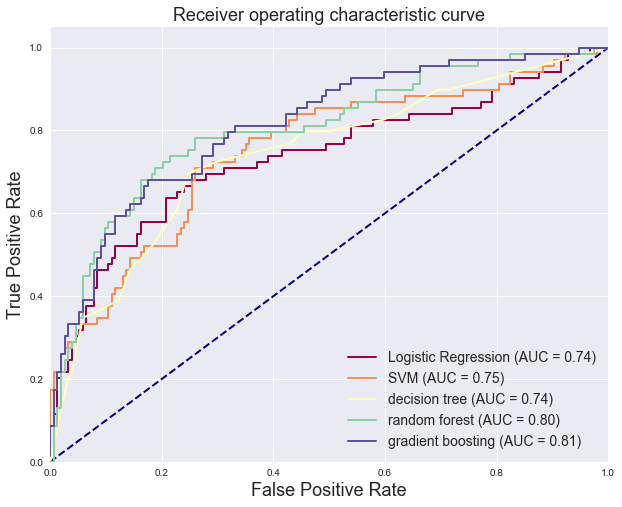

In [7]:
plot_funcs.plot_roc_all(X_test, y_test, pat =pat)

### Ensemble SVM, Logistic Regression, Random Forest and Gradient Boosting using hard vote

In [8]:

X_train, X_test, y_train, y_test = JJ.get_ml_data(data, patid, if_scaler = 1, if_remove_icd = 1)
#parameter_tuning(X_train, X_test, y_train, y_test, classifier = 1, C_range_num = 100, if_save = 1)

print("The accuracy for ensemble model is")
JJ.ensemble_model(X_train, y_train, X_test, y_test, patid = patid,if_save = 0)

AttributeError: module 'jj_basic_fn' has no attribute 'get_ml_data'

## 4. Feature Importance

### Feature Importance for Logistic regression

In [ ]:
plot_funcs.feature_importance(pat,1)

### Feature Importance for Gradient Boosting

In [ ]:
plot_funcs.feature_importance(pat,7)

## 5. Data visualization

## Pairwise features scatter plot

### Each data point corresponds to a .dat file. Red points means it is in a good epoch, and blue points means it is in a bad epoch.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data_ml = JJ.get_scatter_plot_data(data, patid)
sns.set(font_scale=2)
colors = ["baby pink", "neon blue", "bright red", "sky"]
g = sns.pairplot(data_ml, hue="label_sti", size = 6, vars=JJ.get_variable_name(features_list), plot_kws={"s": 5},palette=sns.xkcd_palette(colors))
plt.show()

### 3D scatter plot

In [ ]:
%matplotlib notebook
sns.set(font_scale=1)

JJ.scatter_plot_3d(data,patid, var_list = plot_3d_var_list)
